## **Anomaly Detection with Autoencoders**

In [1]:
import pandas as pd
import numpy as np
import glob
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
#For google colab
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
#Your path
%cd '/content/drive/MyDrive/project/'

Mounted at /content/drive
/content/drive/MyDrive/project


In [3]:
#Import and concat all files
path = r'S5_database/A1Benchmark' #set the path accordingly
all_files=glob.glob(path+"/*.csv")

In [4]:
preprocessed_dfs = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df['value'] = df['value'].replace(0, np.nan)
    df = df.dropna(subset=['value'])

    # Normalize the 'value' column
    normalized_values = preprocessing.normalize([df['value'].to_numpy()])[0]
    df['value'] = normalized_values

    preprocessed_dfs.append(df)

concatenated_df = pd.concat(preprocessed_dfs, axis=0, ignore_index=True)

In [ ]:
# I save the result, so I just read it from the result
#concatenated_df=pd.read_csv("final_dataset.csv")

In [5]:
concatenated_df

,timestamp,value,is_anomaly
0,1,7.585836e-07,0
1,2,1.444452e-03,0
2,3,3.023026e-02,0
3,4,3.017998e-02,0
4,5,2.915941e-02,0
...,...,...,...
92673,1435,1.204849e-02,0
92674,1436,1.272917e-02,0
92675,1437,1.298406e-02,0
92676,1438,1.432975e-02,0


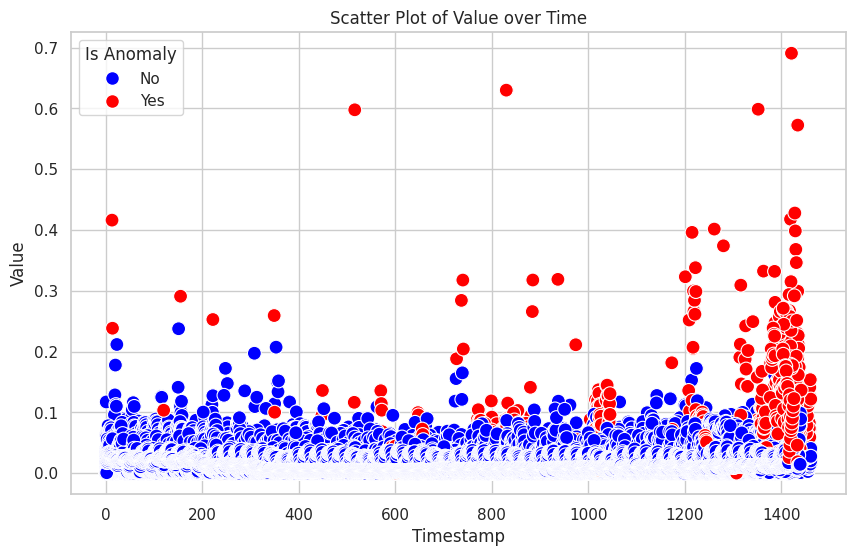

In [ ]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Create a scatter plot with seaborn
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(x='timestamp', y='value', hue='is_anomaly', data=concatenated_df, palette={0: 'blue', 1: 'red'}, s=100)

# Create custom legend handles
legend_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10)
]

# Add legend with custom handles
plt.legend(handles=legend_handles, title='Is Anomaly', labels=['No', 'Yes'], loc='upper left')


# Set plot title and labels
plt.title('Scatter Plot of Value over Time')
plt.xlabel('Timestamp')
plt.ylabel('Value')

# Show the plot
plt.show()

In [6]:
#function to convert dataframe to into 2d array
#creating sliding window of length 60 values in a sequence

def convert_2d(df):
    rows = []

    for i in range(len(df) - 59):
        segment = df.iloc[i:i+60]
        is_anomaly = segment['is_anomaly'].any()
        new_row = segment['value'].tolist() + [int(is_anomaly)]
        rows.append(new_row)
    data_frame = pd.DataFrame(rows)

    return data_frame

In [7]:
sw_df = convert_2d(concatenated_df)
sw_df

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,7.585836e-07,0.001444,0.030230,0.030180,0.029159,0.027023,0.022884,0.018460,0.015671,0.014503,...,0.031096,0.030752,0.027536,0.022239,0.017144,0.015028,0.014126,0.013677,0.013576,0
1,1.444452e-03,0.030230,0.030180,0.029159,0.027023,0.022884,0.018460,0.015671,0.014503,0.013918,...,0.030752,0.027536,0.022239,0.017144,0.015028,0.014126,0.013677,0.013576,0.013570,0
2,3.023026e-02,0.030180,0.029159,0.027023,0.022884,0.018460,0.015671,0.014503,0.013918,0.013690,...,0.027536,0.022239,0.017144,0.015028,0.014126,0.013677,0.013576,0.013570,0.014163,0
3,3.017998e-02,0.029159,0.027023,0.022884,0.018460,0.015671,0.014503,0.013918,0.013690,0.013602,...,0.022239,0.017144,0.015028,0.014126,0.013677,0.013576,0.013570,0.014163,0.016680,0
4,2.915941e-02,0.027023,0.022884,0.018460,0.015671,0.014503,0.013918,0.013690,0.013602,0.013782,...,0.017144,0.015028,0.014126,0.013677,0.013576,0.013570,0.014163,0.016680,0.022150,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92614,1.153728e-02,0.011584,0.010254,0.012608,0.011782,0.011218,0.010180,0.011537,0.011655,0.013314,...,0.291808,0.427976,0.398546,0.368142,0.346424,0.251375,0.046235,0.018834,0.012048,1
92615,1.158427e-02,0.010254,0.012608,0.011782,0.011218,0.010180,0.011537,0.011655,0.013314,0.014183,...,0.427976,0.398546,0.368142,0.346424,0.251375,0.046235,0.018834,0.012048,0.012729,1
92616,1.025425e-02,0.012608,0.011782,0.011218,0.010180,0.011537,0.011655,0.013314,0.014183,0.012276,...,0.398546,0.368142,0.346424,0.251375,0.046235,0.018834,0.012048,0.012729,0.012984,1
92617,1.260813e-02,0.011782,0.011218,0.010180,0.011537,0.011655,0.013314,0.014183,0.012276,0.013794,...,0.368142,0.346424,0.251375,0.046235,0.018834,0.012048,0.012729,0.012984,0.014330,1


In [ ]:
#concatenated_df.to_csv('final_dataset.csv', index=False)

[[24417   819]
 [ 1257  1293]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     25236
           1       0.61      0.51      0.55      2550

    accuracy                           0.93     27786
   macro avg       0.78      0.74      0.76     27786
weighted avg       0.92      0.93      0.92     27786



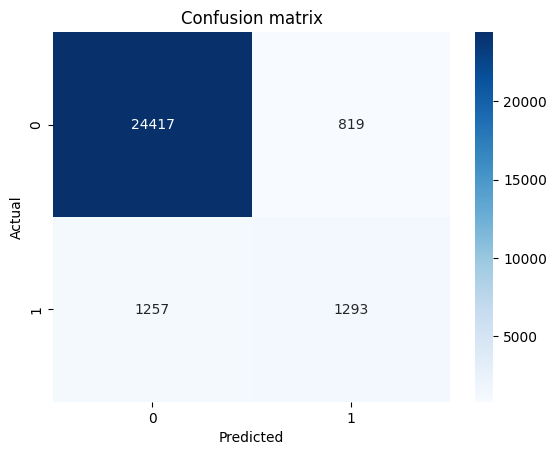

Accuracy: 0.9253
Precision: 0.6122
Recall: 0.5071
F1-Score: 0.5547


In [8]:
# first try random forest and see how the model performs

# Splitting the dataset into training and testing sets
y = sw_df.iloc[:, 60]
X = sw_df.iloc[:, 0:60]

# Train-test split
#no shuffling since we are using sliding window
train_size = int(0.7 * len(X))
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

# Creating a Random Forest classifier object
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
# Fitting the Random Forest classifier to the training data
rfc.fit(X_train, y_train)

# Making predictions on the testing data
y_pred = rfc.predict(X_test)

# Printing the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate Precision
precision = precision_score(y_test, y_pred)

# Calculate Recall
recall = recall_score(y_test, y_pred)

# Calculate F1-Score
f1 = f1_score(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

**Anomaly Detection with Autoencoders with Pytorch**

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [10]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = scaler.fit_transform(X_test)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader for training
dataset = TensorDataset(X_train, X_train)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)



<ipython-input-12-c4aa05343569>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)


In [13]:
# Instantiate the autoencoder
input_dim = X_train.shape[1]
autoencoder = Autoencoder(input_dim)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.005)

In [14]:
num_epochs = 100
epoch_losses = []

for epoch in range(num_epochs):
    total_loss = 0.0
    for batch in dataloader:
        inputs, _ = batch
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    epoch_loss = total_loss / len(dataloader)
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/100, Loss: 0.4728
Epoch 2/100, Loss: 0.2914
Epoch 3/100, Loss: 0.2478
Epoch 4/100, Loss: 0.2207
Epoch 5/100, Loss: 0.2085
Epoch 6/100, Loss: 0.2000
Epoch 7/100, Loss: 0.1943
Epoch 8/100, Loss: 0.1885
Epoch 9/100, Loss: 0.1832
Epoch 10/100, Loss: 0.1784
Epoch 11/100, Loss: 0.1756
Epoch 12/100, Loss: 0.1711
Epoch 13/100, Loss: 0.1675
Epoch 14/100, Loss: 0.1648
Epoch 15/100, Loss: 0.1621
Epoch 16/100, Loss: 0.1607
Epoch 17/100, Loss: 0.1580
Epoch 18/100, Loss: 0.1544
Epoch 19/100, Loss: 0.1531
Epoch 20/100, Loss: 0.1505
Epoch 21/100, Loss: 0.1483
Epoch 22/100, Loss: 0.1483
Epoch 23/100, Loss: 0.1471
Epoch 24/100, Loss: 0.1469
Epoch 25/100, Loss: 0.1445
Epoch 26/100, Loss: 0.1433
Epoch 27/100, Loss: 0.1430
Epoch 28/100, Loss: 0.1426
Epoch 29/100, Loss: 0.1419
Epoch 30/100, Loss: 0.1399
Epoch 31/100, Loss: 0.1398
Epoch 32/100, Loss: 0.1394
Epoch 33/100, Loss: 0.1391
Epoch 34/100, Loss: 0.1385
Epoch 35/100, Loss: 0.1379
Epoch 36/100, Loss: 0.1394
Epoch 37/100, Loss: 0.1355
Epoch 38/1

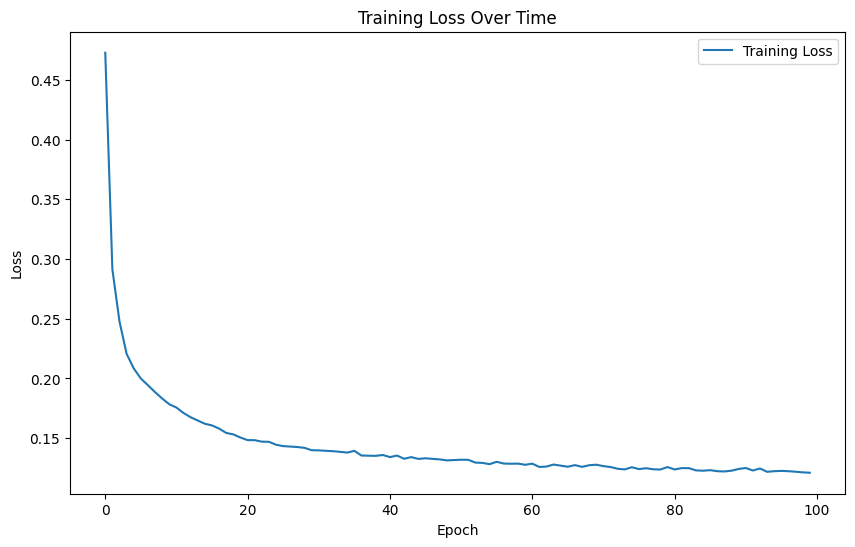

In [15]:
# Plotting the training loss
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

In [16]:
# Extract the encoder for feature representation
encoder = autoencoder.encoder

class Classifier(nn.Module):
    def __init__(self, encoder):
        super(Classifier, self).__init__()
        self.encoder = encoder
        self.fc = nn.Linear(16, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = torch.sigmoid(self.fc(x))
        return x

# Instantiate the classifier
classifier = Classifier(encoder)

# Define the loss function and optimizer for the classifier
criterion_classifier = nn.BCELoss()
optimizer_classifier = optim.Adam(classifier.parameters(), lr=0.001)

# Convert labels to PyTorch tensor
y_train = y_train.view(-1, 1)

# Training loop for the classifier
num_classifier_epochs = 100

for epoch in range(num_classifier_epochs):
    optimizer_classifier.zero_grad()
    outputs = classifier(X_train)
    loss = criterion_classifier(outputs, y_train)
    loss.backward()
    optimizer_classifier.step()

    print(f"Classifier Epoch {epoch+1}/{num_classifier_epochs}, Loss: {loss.item():.4f}")

Classifier Epoch 1/100, Loss: 0.6713
Classifier Epoch 2/100, Loss: 0.6376
Classifier Epoch 3/100, Loss: 0.6090
Classifier Epoch 4/100, Loss: 0.5853
Classifier Epoch 5/100, Loss: 0.5660
Classifier Epoch 6/100, Loss: 0.5506
Classifier Epoch 7/100, Loss: 0.5386
Classifier Epoch 8/100, Loss: 0.5293
Classifier Epoch 9/100, Loss: 0.5221
Classifier Epoch 10/100, Loss: 0.5164
Classifier Epoch 11/100, Loss: 0.5117
Classifier Epoch 12/100, Loss: 0.5075
Classifier Epoch 13/100, Loss: 0.5034
Classifier Epoch 14/100, Loss: 0.4993
Classifier Epoch 15/100, Loss: 0.4949
Classifier Epoch 16/100, Loss: 0.4902
Classifier Epoch 17/100, Loss: 0.4853
Classifier Epoch 18/100, Loss: 0.4801
Classifier Epoch 19/100, Loss: 0.4749
Classifier Epoch 20/100, Loss: 0.4696
Classifier Epoch 21/100, Loss: 0.4643
Classifier Epoch 22/100, Loss: 0.4593
Classifier Epoch 23/100, Loss: 0.4544
Classifier Epoch 24/100, Loss: 0.4499
Classifier Epoch 25/100, Loss: 0.4456
Classifier Epoch 26/100, Loss: 0.4416
Classifier Epoch 27/1

In [17]:
# Check if GPU is available and use it, otherwise use CPU
device = torch.device("cpu")
autoencoder.to(device)
classifier.to(device)

Classifier(
  (encoder): Sequential(
    (0): Linear(in_features=60, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [22]:
# Create DataLoader for the test set
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Set the model to evaluation mode
autoencoder.eval()
classifier.eval()

# Lists to store true labels and predicted labels
predicted_labels = []

# Evaluation loop
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Pass inputs through the autoencoder
        encoded_features = autoencoder(inputs)

        # Pass encoded features through the classifier
        outputs = classifier(encoded_features)

        # Assuming binary classification
        predicted = (outputs > 0.5).float()

        # Convert PyTorch tensors to NumPy arrays
        predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to NumPy arrays
predicted_labels = np.array(predicted_labels)

# Convert y_test to NumPy array
y_test_np = y_test.cpu().numpy()

# Calculate Accuracy, Precision, Recall, and F1-Score
accuracy = accuracy_score(y_test_np, predicted_labels)
precision = precision_score(y_test_np, predicted_labels)
recall = recall_score(y_test_np, predicted_labels)
f1 = f1_score(y_test_np, predicted_labels)

# Print the results
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1-Score: {f1 * 100:.2f}%')


Accuracy: 92.54%
Precision: 68.80%
Recall: 34.16%
F1-Score: 45.65%


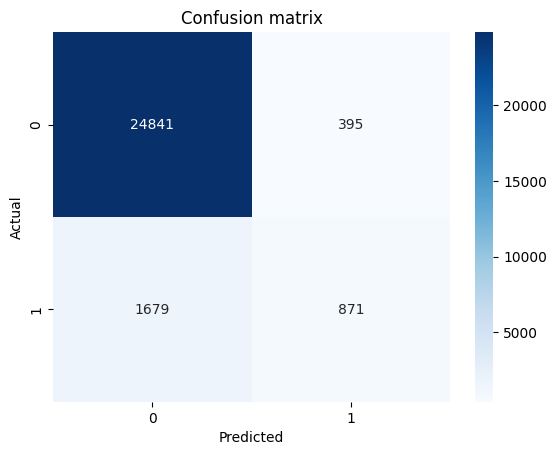

In [21]:
# Plotting the confusion matrix
cm = confusion_matrix(y_test_np, predicted_labels)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()